<a href="https://colab.research.google.com/github/tkbharadwaj/vggnet/blob/main/VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

```
https://github.com/tkbharadwaj/vggnet
```
Tejas Bharadwaj <br>
7/6/23 <br>
Classifier for CIFAR-10 Dataset <br>
Goal: 90% testing accuracy <br>
Some code borrowed & modified from:

```
https://github.com/patrickloeber/pytorchTutorial/blob/master/14_cnn.py
```



Import Modules, Initialize Hyperparameters

In [2]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from torchsummary import summary
import torchvision
import torchvision.transforms as transforms
import math

import random

import matplotlib.pyplot as plt
from matplotlib import animation
from tqdm import trange
device = torch.device("cuda:0")
batch_size = 128
learning_rate = .001
num_epochs = 50

Load Dataset,
normalize + transform using RandomCrop and HorizontalFlip for model's resilience

Dataset used is CIFAR-10


In [3]:
transform = transforms.Compose(
    [ transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))],)
train_set = torchvision.datasets.CIFAR10(root = "/content", download = True, train = True, transform =transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transform]))
test_set = torchvision.datasets.CIFAR10(root = "/content", download = True, train = False, transform = transform)

train_load = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
test_load = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = True)

classes = ('airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship',  'truck')

print(train_load)


100%|██████████| 170498071/170498071 [00:05<00:00, 28460137.17it/s]


Extracting /content/cifar-10-python.tar.gz to /content
Files already downloaded and verified


Implementation of VGG-13 Network by Tejas Bharadwaj <br>
Original Paper: ``` https://arxiv.org/pdf/1409.1556v6.pdf ``` <br>
Weight Initialization done according to "Understanding the difficulty of training deep feedforward neural networks - Glorot, X. & Bengio, Y. (2010)" <br>

In [4]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,64, kernel_size=3, stride =1, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64,64, kernel_size=3, stride =1, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64,128, kernel_size=3, stride =1, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128,128, kernel_size=3, stride =1, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128,256, kernel_size=3, stride =1, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size=3, stride =1, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(256,512, kernel_size=3, stride =1, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512,512, kernel_size=3, stride =1, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(512,512, kernel_size=3, stride =1, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512,512, kernel_size=3, stride =1, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.fc1 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(512, 10)
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.xavier_uniform_(m.weight.data, gain = 0.5)
                m.bias.data.zero_()

    def forward(self, x):
      #conv layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
      #fully connected layers
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x


model = VGG()
model = model.to(device)
summary(model, (3, 32 , 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
        MaxPool2d-14            [-1, 12

In [5]:
def learning_rate_decay(model, optimizer, decay = 0.5):
  for param_group in optimizer.param_groups:
        param_group['lr'] = decay*param_group['lr']

In [ ]:
x = []
vali_loss_history = []
train_loss_history = []
accuracy_history = []

tl_count = 0
vl_count = 0

plt.ylim([0, 100])
plt.xlim([0, 250])
plt.xlabel("#epochs")
plt.ylabel("Accuracy (%)")



Train the model


In [7]:
plt.show()
num_epochs = 110
count = 1
count2 = 0
learning_rate = .01
decay_after_epochs = [80, 20, 12]
model = VGG().to(device)
wd = 5*10**(-4) #from original paper
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, weight_decay = wd)

n_total_steps = len(train_load)

with trange(1, num_epochs+1) as t:
  mloss = 0
  for epoch in t:
      x.append(epoch)
      model.train()
      #learning rate decay ** make into function
      if count % decay_after_epochs[count2] == 0:
        learning_rate_decay(model, optimizer, .1)
        count = 0
        count2 = count2 + 1
      count += 1
      train_loss_history.append(0)
      for i, (images, labels) in enumerate(train_load):
          images = images.to(device)
          outputs = model(images)
          outputs = outputs.to(device)
          labels = labels.to(device)
          loss = criterion(outputs, labels)
          #print(loss)
          train_loss_history[tl_count] += loss.item()
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          mloss = loss.item()
      train_loss_history[tl_count] /= len(train_load)
      tl_count += 1
      model.eval()
      with torch.no_grad():
        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for i in range(10)]
        n_class_samples = [0 for i in range(10)]
        vali_loss_history.append(0)
        for images, labels in test_load:
            images = images.to(device)
            outputs = model(images)
            labels = labels.to(device)
            outputs = outputs.to(device)
            loss = criterion(outputs, labels)
            vali_loss_history[vl_count] += loss.item()
            _, predicted = torch.max(outputs, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            for i in range(batch_size):
                if i >= len(labels):
                  break;
                label = labels[i]
                pred = predicted[i]
                if (label == pred):
                    n_class_correct[label] += 1
                n_class_samples[label] += 1
        vali_loss_history[vl_count] /= len(test_load)
        vl_count += 1


        acc = 100.0 * n_correct / n_samples
        t.set_description('Epoch %i' % epoch)
        t.set_postfix(training_loss=mloss, test_accuracy=acc)
        accuracy_history.append(acc)

Epoch 110: 100%|██████████| 110/110 [1:15:01<00:00, 40.93s/it, test_accuracy=91.4, training_loss=0.00808]


Depict the models' training and validation loss in order to optimize #epochs hyperparameter \*\*make dynamic plotting\*\*

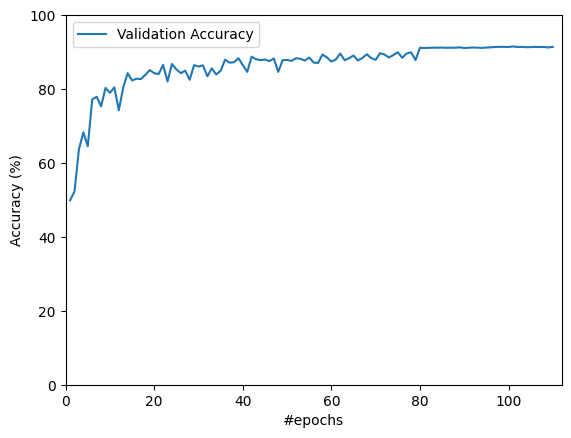

In [10]:
plt.ylim([0, 100])
plt.xlim([0, num_epochs+2])
plt.xlabel("#epochs")
plt.ylabel("Accuracy (%)")
#print(train_loss_history)
plt.plot(x, accuracy_history, label = "Validation Accuracy")

#print(vali_loss_history)
#plt.plot(x, vali_loss_history, label = "Validation")

plt.legend()
plt.show()

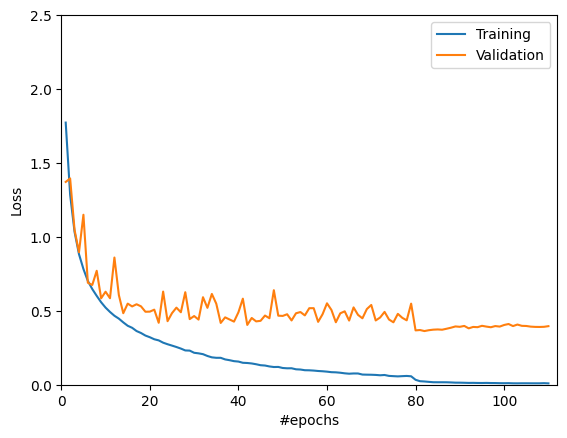

In [12]:
plt.ylim([0, 2.5])
plt.xlim([0, num_epochs+2])
plt.xlabel("#epochs")
plt.ylabel("Loss")
#print(train_loss_history)
plt.plot(x, train_loss_history, label = "Training")

#print(vali_loss_history)
plt.plot(x, vali_loss_history, label = "Validation")

plt.legend()
plt.show()